# ML on ESDC using TensorFlow 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library TensorFlow. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with tensorflow installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/). You can follow the experiment run via the bundled Tensorboard UI.**

### Import necessary libraries

In [1]:
import datetime, os
import xarray as xr
import dask.array as da
import numpy as np
import pandas as pd
from xcube.core.store import new_data_store

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K

from sklearn.metrics import r2_score, mean_squared_error

from global_land_mask import globe
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import tqdm as notebook_tqdm

2024-01-23 08:42:56.095811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 08:42:56.225734: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 08:42:57.099023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib:/usr/lib/x86_64-linux-gnu
2024-01-23 08:42:57.099105: W tensorflow/compiler/xl

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
ds = dataset[['land_surface_temperature', 'air_temperature_2m']]
ds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [3]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0 = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [4]:
lm = da.stack([lm0 for i in range(ds.dims['time'])], axis = 0)
lm

dask.array<stack, shape=(1840, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [5]:
from mltools.cube_utilities import get_chunk_sizes

xdsm = ds.assign(land_mask= (['time','lat','lon'],lm.rechunk(chunks=([v for k,v in get_chunk_sizes(ds)]))))
xdsm

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube to a pandas dataframe.

In [6]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 89.958333 -179.958333                       NaN          266.297180   
           -179.875000                       NaN          266.297180   
           -179.791667                       NaN          266.297180   
           -179.708333                       NaN          266.297180   
           -179.625000                       NaN          266.297180   
...                                          ...                 ...   
-89.958333  179.625000                       NaN          219.817398   
            179.708333                       NaN          219.817398   
            179.791667                       NaN          219.817398   
            179.875000                       NaN          219.817398   
            179.958333                       NaN          219.817398   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

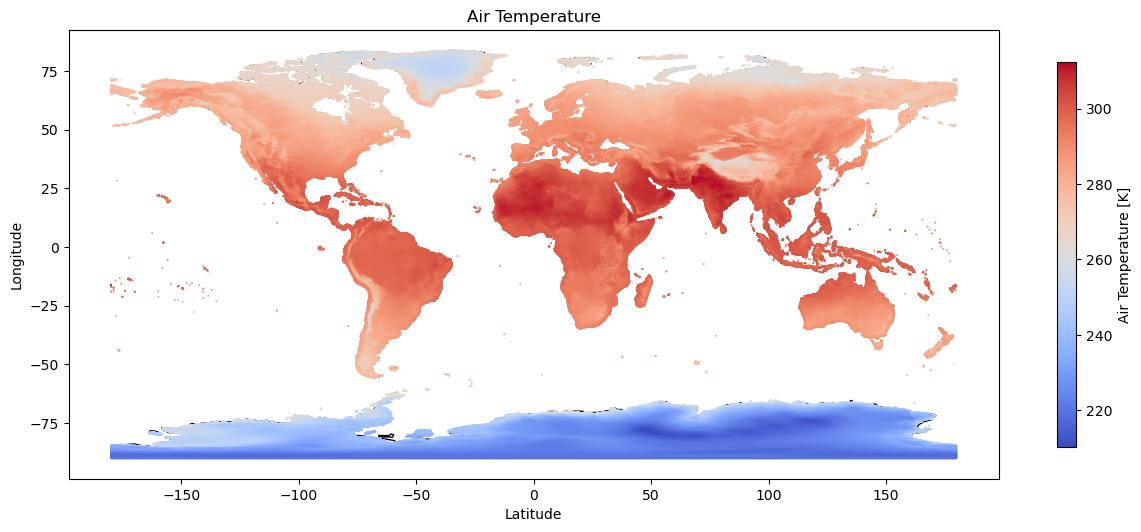

In [7]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'air_temperature_2m', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Air Temperature [K]'})

plt.title('Air Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('air_temp_masked.png')

Land Surface Temperature

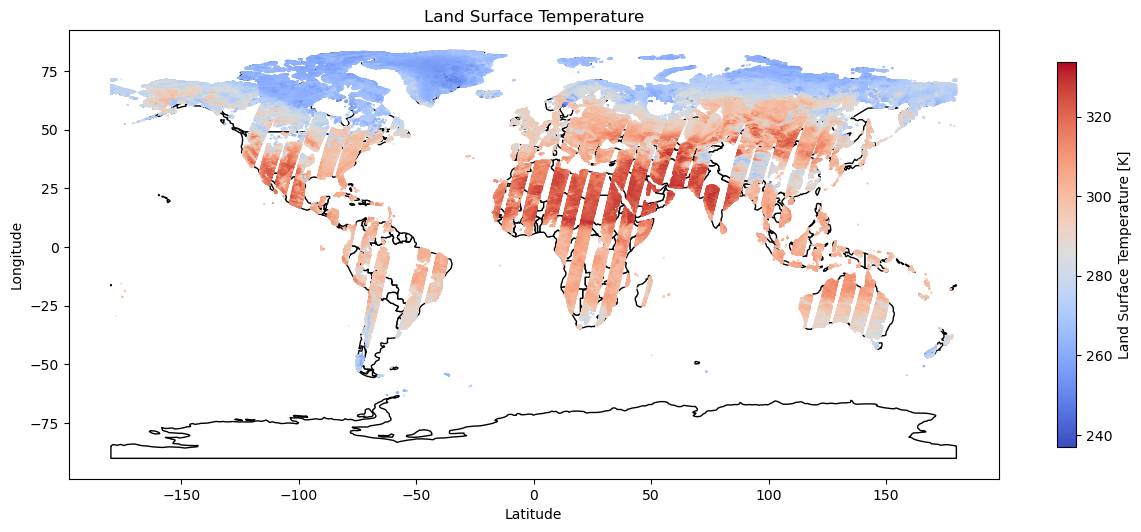

In [8]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'})

plt.title('Land Surface Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('land_surface_temperature.png')

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [9]:
from mltools.data_assignment import assign_split, rand

# random sampling
#xds = ds.assign({"split": rand})

# block sampling
xds = assign_split(xdsm, block_size=[("time", 10), ("lat", 100), ("lon", 100)], split=0.7)
xds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

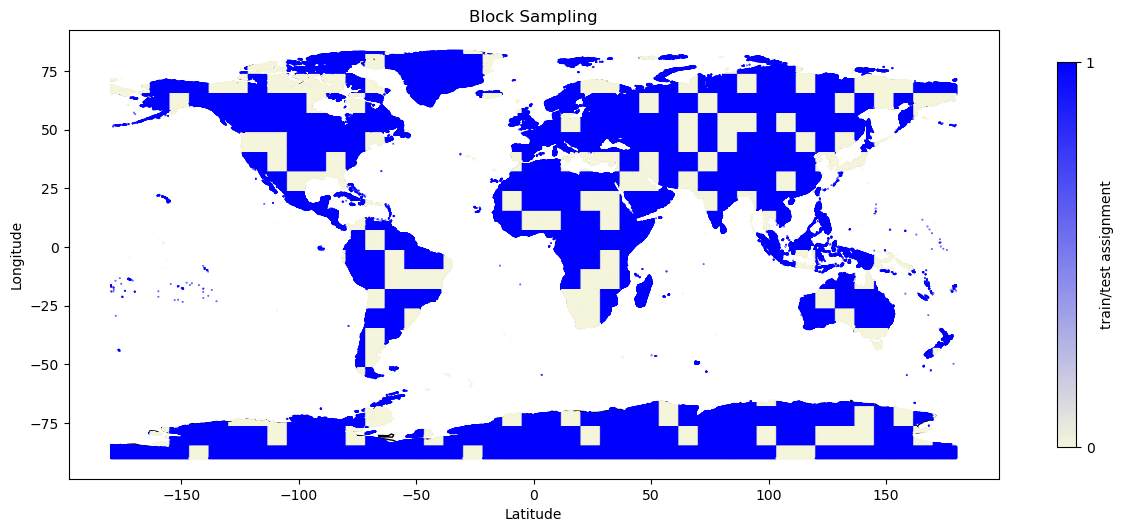

In [10]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'split', cmap = LinearSegmentedColormap.from_list("", ["beige","blue"]), legend = True, legend_kwds={
        "shrink":.5, 'label': 'train/test assignment', 'ticks': [0,1]}) 

plt.title('Block Sampling')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('train_test_assignment.png')

### Model set up

In [11]:
def create_model():
    inputs = L.Input(name="air_temperature_2m", shape=(1,))
    output = L.Dense(1, activation="linear", name="land_surface_temperature")(inputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics="mae")
    return model

model = create_model()
model.summary()

2024-01-23 08:53:06.341593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-23 08:53:06.465150: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib:/usr/lib/x86_64-linux-gnu
2024-01-23 08:53:06.465383: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-23 08:53:06.465891: I tensorflow/core/platform/cpu_feature_guard.cc:1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 air_temperature_2m (InputLa  [(None, 1)]              0         
 yer)                                                            
                                                                 
 land_surface_temperature (D  (None, 1)                2         
 ense)                                                           
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [12]:
K.set_value(model.optimizer.learning_rate, 0.0001)

Enable logging for Tensorboard

In [13]:
log_dir = os.environ.get('TENSORBOARD_LOGDIR') + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [14]:
from mltools.data_processing import getRange, getStatistics

#at_range = getRange(xds, 'air_temperature_2m')
#lst_range = getRange(xds, 'land_surface_temperature')

at_stat = getStatistics(xds, 'air_temperature_2m')
lst_stat = getStatistics(xds, 'land_surface_temperature')

### Train model

We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [ ]:
from mltools.data_processing import standardize
from mltools.cube_utilities import iter_data_var_blocks

for chunk in iter_data_var_blocks(xds): 
    ### preprocessing
    # flatten
    cf = {x: chunk[x].ravel() for x in chunk.keys()}
    # choose land values
    lm = cf['land_mask']
    cft = {x: cf[x][lm == True] for x in cf.keys()}
    # drop nans
    lst = cft['land_surface_temperature']
    cfn = {x: cft[x][~np.isnan(lst)] for x in cf.keys()}

    if len(cfn['land_surface_temperature']) > 0:
        X = standardize(cfn['air_temperature_2m'],*at_stat)
        y = standardize(cfn['land_surface_temperature'], *lst_stat)
        
        ### get train/test data
        X_train = X[cfn['split']==True]
        X_test  = X[cfn['split']==False]
        y_train = y[cfn['split']==True]
        y_test  = y[cfn['split']==False]
        
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        
        ### train model
        model.fit(train_ds.batch(100).take(10000),validation_data=test_ds.batch(100).take(2000), epochs=3, callbacks=[tensorboard_callback])

495/495 [==============================] - 1s 2ms/step - loss: 0.4519 - mae: 0.4994 - val_loss: 2.2970 - val_mae: 1.2510
Epoch 1/3
1469/1469 [==============================] - 2s 2ms/step - loss: 0.8589 - mae: 0.6787 - val_loss: 2.2897 - val_mae: 1.3056
Epoch 2/3
1469/1469 [==============================] - 2s 2ms/step - loss: 0.7962 - mae: 0.6583 - val_loss: 2.0861 - val_mae: 1.2435
Epoch 3/3
1469/1469 [==============================] - 2s 2ms/step - loss: 0.7469 - mae: 0.6430 - val_loss: 1.9081 - val_mae: 1.1870
Epoch 1/3
2461/2461 [==============================] - 4s 2ms/step - loss: 0.9696 - mae: 0.7726 - val_loss: 0.6759 - val_mae: 0.6476
Epoch 2/3
2461/2461 [==============================] - 4s 1ms/step - loss: 0.7875 - mae: 0.7067 - val_loss: 0.5360 - val_mae: 0.5774
Epoch 3/3
2461/2461 [==============================] - 4s 1ms/step - loss: 0.6566 - mae: 0.6567 - val_loss: 0.4361 - val_mae: 0.5240
Epoch 1/3
2906/2906 [==============================] - 5s 2ms/step - loss: 0.4517

### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [ ]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

Predict missing Land Surface Temperature values from Air Temperature values

In [ ]:
from mltools.data_processing import standardize, undo_standardizing

dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = standardize(to_pred['air_temperature_2m'], *at_stat)
X = X.values

lstp = model.predict(X.reshape(-1, 1))
output['land_surface_temperature'] = undo_standardizing(lstp, *at_stat)
output

### Plot Predictions

In [ ]:
df = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

geometry = [Point(xy) for xy in zip(lst['lon'], lst['lat'])]
gdf = GeoDataFrame(lst, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'land_surface_temperature', cmap = 'coolwarm', vmin = 195, vmax = 335, legend = True, 
    legend_kwds={"shrink":.5, 'label': 'Land Surface Temperature [K]'})

plt.title('Landsurface Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#fname = 'xxx' +'.png'
#plt.savefig(fname)
plt.show()